# Intermediate Exam
Student: Ana Carolina Souza <br>
<a href= "https://www.kaggle.com/datasets/setseries/news-category-dataset/data">Dataset</a> <br>
<a href= "https://arxiv.org/pdf/1810.00968">Business Case</a>

## 1. Choose a labeled text dataset used for classification. 
This dataset must have at least one source indicating its business purpose. For example: there could be a scientific article that uses that dataset for something, or there could be clear notes on what is the business application related to the dataset. You must cite the source for this information, and paraphrase it in a sentence or short paragraph. You are not allowed to invent a business case or to use datasets with no business case. This step is important because we want to have meaningful results in situations that are as close to reality as we can get.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle
import nltk
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score

# Download necessary NLTK data
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

In [7]:
# pd.options.display.max_columns = None
# pd.set_option('display.max_colwidth', None)

df = pd.read_csv('dataset/NewsCategorizer.csv', encoding='utf-8')

# Drop columns that are not needed
df = df.drop(columns=['keywords', 'links'])

# Merge "headline" and "short_description" into "text"
df['text'] = df['headline'] + " " + df['short_description']

In [8]:
display(df.head(10))

,category,headline,short_description,text
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,Resting is part of training. I've confirmed wh...,143 Miles in 35 Days: Lessons Learned Resting ...
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,Think of talking to yourself as a tool to coac...,Talking to Yourself: Crazy or Crazy Helpful? T...
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,The clock is ticking for the United States to ...,Crenezumab: Trial Will Gauge Whether Alzheimer...
3,WELLNESS,"Oh, What a Difference She Made","If you want to be busy, keep trying to be perf...","Oh, What a Difference She Made If you want to ..."
4,WELLNESS,Green Superfoods,"First, the bad news: Soda bread, corned beef a...","Green Superfoods First, the bad news: Soda bre..."
5,WELLNESS,Bad Love Advice: 9 Lessons To Unlearn,"By Carey Moss for YouBeauty.com Love rom-coms,...",Bad Love Advice: 9 Lessons To Unlearn By Carey...
6,WELLNESS,The Happiest (And Unhappiest) States In The U.S.,The nation in general scored a 66.2 in 2011 on...,The Happiest (And Unhappiest) States In The U....
7,WELLNESS,Seaweed: The Green Superfood You're Not Eating...,It's also worth remembering that if the water ...,Seaweed: The Green Superfood You're Not Eating...
8,WELLNESS,Addicted to Food?,"If you look at our culture's eating behavior, ...",Addicted to Food? If you look at our culture's...
9,WELLNESS,High Tech Works When It Enables High Touch,"François-Marie Arouet, 18th century French aut...",High Tech Works When It Enables High Touch Fra...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   short_description  50000 non-null  object
 3   text               50000 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


<AxesSubplot: title={'center': 'Data Distribution'}, xlabel='Category', ylabel='Count'>

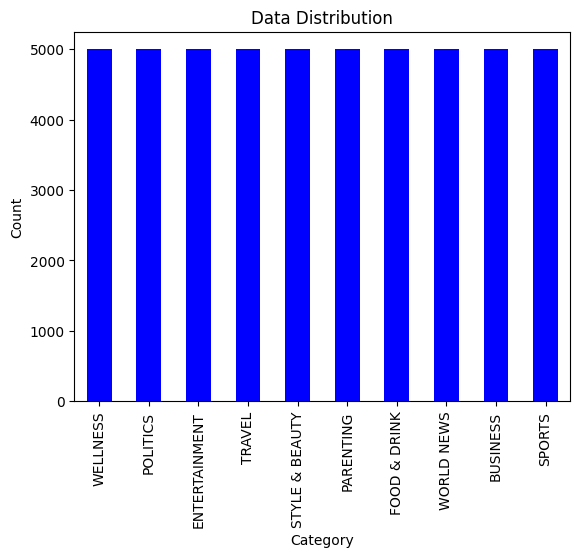

In [10]:
df['category'].value_counts().plot(kind='bar',title='Data Distribution', color='blue', ylabel='Count', xlabel='Category')

## 2. Define a classification pipeline.
Include pre-processing steps and feature engineering, possibly using stemming, lemmatization, removal of particular words, and/or text augmentation with wordnet. In this step, briefly review the models and assumptions. In special, for the bag-of-words model, discuss why it makes sense to use the presence of particular words for that specific classification problem, and try to find counter-examples in which this assumption could be purposefully exploited to confuse the classifier.

In [11]:
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize
    processed = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    
    return ' '.join(processed)

In [12]:
df['processed_text'] = df['text'].apply(preprocess)

In [13]:
df.head(10)

,category,headline,short_description,text,processed_text
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,Resting is part of training. I've confirmed wh...,143 Miles in 35 Days: Lessons Learned Resting ...,143 mile 35 day lesson learned resting part tr...
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,Think of talking to yourself as a tool to coac...,Talking to Yourself: Crazy or Crazy Helpful? T...,talking crazy crazy helpful think talking tool...
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,The clock is ticking for the United States to ...,Crenezumab: Trial Will Gauge Whether Alzheimer...,crenezumab trial gauge whether alzheimer drug ...
3,WELLNESS,"Oh, What a Difference She Made","If you want to be busy, keep trying to be perf...","Oh, What a Difference She Made If you want to ...",oh difference made want busy keep trying perfe...
4,WELLNESS,Green Superfoods,"First, the bad news: Soda bread, corned beef a...","Green Superfoods First, the bad news: Soda bre...",green superfoods first bad news soda bread cor...
5,WELLNESS,Bad Love Advice: 9 Lessons To Unlearn,"By Carey Moss for YouBeauty.com Love rom-coms,...",Bad Love Advice: 9 Lessons To Unlearn By Carey...,bad love advice 9 lesson unlearn carey moss lo...
6,WELLNESS,The Happiest (And Unhappiest) States In The U.S.,The nation in general scored a 66.2 in 2011 on...,The Happiest (And Unhappiest) States In The U....,happiest unhappiest state nation general score...
7,WELLNESS,Seaweed: The Green Superfood You're Not Eating...,It's also worth remembering that if the water ...,Seaweed: The Green Superfood You're Not Eating...,seaweed green superfood eating also worth reme...
8,WELLNESS,Addicted to Food?,"If you look at our culture's eating behavior, ...",Addicted to Food? If you look at our culture's...,addicted food look culture eating behavior cer...
9,WELLNESS,High Tech Works When It Enables High Touch,"François-Marie Arouet, 18th century French aut...",High Tech Works When It Enables High Touch Fra...,high tech work enables high touch arouet 18th ...


(40000,) (10000,)


<AxesSubplot: title={'center': 'Train Data Distribution'}, xlabel='Category', ylabel='Percentage'>

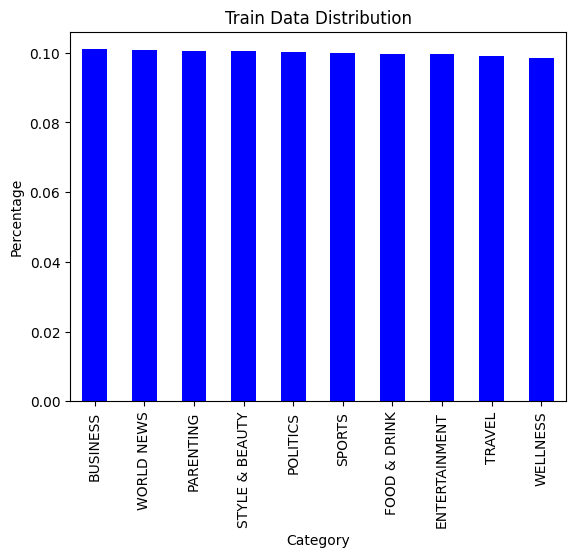

In [14]:
X = df['processed_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)

print(X_train.shape, X_test.shape)
y_train.value_counts(normalize=True).plot(kind='bar', title='Train Data Distribution', color='blue', ylabel='Percentage', xlabel='Category')

In [15]:
# Define Bag-of-Words model with Logistic Regression classifier
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(solver='saga', max_iter=1000, multi_class='multinomial'))
])

# Training takes about 7 minutes, so retraining is not recommended. Saving the model for future use
try:
    with open('model_balanced.pkl', 'rb') as model_file:
        pipeline = pickle.load(model_file)
except FileNotFoundError:
    pipeline.fit(X_train, y_train)
    with open('model_balanced.pkl', 'wb') as model_file:
        pickle.dump(pipeline, model_file)

y_pred = pipeline.predict(X_test)
accuracy_test = balanced_accuracy_score(y_test, y_pred)
y_pred_train = pipeline.predict(X_train)
accuracy_train = balanced_accuracy_score(y_train, y_pred_train)

In [16]:
print(f'Train Accuracy: {accuracy_train}')
print(f'Test Accuracy: {accuracy_test}')

Train Accuracy: 0.9936254447514085
Test Accuracy: 0.8080513513092938


In [17]:
# get top 10 important words for each category
vectorizer = pipeline.named_steps['vectorizer']
classifier = pipeline.named_steps['classifier']

words = vectorizer.get_feature_names_out()
categories = classifier.classes_

top_words = pd.DataFrame(index=categories, columns=np.arange(10))
for i, category in enumerate(categories):
    top10 = np.argsort(classifier.coef_[i])[-10:]
    top_words.loc[category] = words[top10]

display(top_words)


,0,1,2,3,4,5,6,7,8,9
BUSINESS,tesla,startup,ceo,leadership,employee,workplace,business,krugman,wall,uber
ENTERTAINMENT,actor,netflix,teaser,film,actress,album,movie,singer,trailer,jenner
FOOD & DRINK,chef,kitchen,taste,cheese,food,cooking,tastemakers,wine,cocktail,recipe
PARENTING,daughter,mom,pregnancy,baby,parent,breastfeeding,toddler,kid,mommy,parenting
POLITICS,obamacare,nra,flint,immigrant,fbi,democrat,congressman,republican,senate,gop
SPORTS,baseball,basketball,sport,curry,football,kobe,espn,lebron,nba,nfl
STYLE & BEAUTY,designer,stylish,wardrobe,stylelist,makeup,beauty,photo,outfit,style,fashion
TRAVEL,destination,traveling,attraction,getaway,hotel,vacation,airline,tsa,traveler,travel
WELLNESS,fitness,yoga,exercise,fearless,mindful,superfoods,calorie,meditation,sleep,workout
WORLD NEWS,yemen,poland,myanmar,brexit,isi,israeli,pakistan,syrian,refugee,saudi


In [18]:
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
report_df = pd.DataFrame(report).transpose()

display(report_df)

,precision,recall,f1-score,support
BUSINESS,0.747681,0.840459,0.791360,959.0000
ENTERTAINMENT,0.793241,0.786207,0.789708,1015.0000
FOOD & DRINK,0.840622,0.853899,0.847209,1013.0000
PARENTING,0.770475,0.782341,0.776363,974.0000
POLITICS,0.771109,0.761044,0.766043,996.0000
SPORTS,0.892891,0.944835,0.918129,997.0000
STYLE & BEAUTY,0.886587,0.825381,0.854890,985.0000
TRAVEL,0.832455,0.762548,0.795970,1036.0000
WELLNESS,0.744560,0.742453,0.743505,1060.0000
WORLD NEWS,0.804696,0.781347,0.792850,965.0000


In [19]:
# top 5 most precise categories and top 5 least precise categories

report_df['precision'] = report_df['precision'].astype(float)
top5_precise = report_df.sort_values('precision', ascending=False).head(5)
least5_precise = report_df.sort_values('precision').head(5)

display(top5_precise)
display(least5_precise)

,precision,recall,f1-score,support
SPORTS,0.892891,0.944835,0.918129,997.0
STYLE & BEAUTY,0.886587,0.825381,0.854890,985.0
FOOD & DRINK,0.840622,0.853899,0.847209,1013.0
TRAVEL,0.832455,0.762548,0.795970,1036.0
macro avg,0.808432,0.808051,0.807603,10000.0


,precision,recall,f1-score,support
WELLNESS,0.744560,0.742453,0.743505,1060.0
BUSINESS,0.747681,0.840459,0.791360,959.0
PARENTING,0.770475,0.782341,0.776363,974.0
POLITICS,0.771109,0.761044,0.766043,996.0
ENTERTAINMENT,0.793241,0.786207,0.789708,1015.0


# 4. Assess the dataset size
Use the strategy of evaluating errors in the train and in the test datasets for various levels of dataset downsampling. According to this assessment, how much room is there to increase your accuracy by increasing the dataset size? Is it feasible given the business case?

In [20]:
fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
train_scores = []
test_scores = []

def compute_scores(frac):
    print(f'Training with {frac * 100}% of the data')

    n_samples = int(frac * len(X))
    df_sampled = df.sample(n=n_samples, random_state=23).reset_index(drop=True)
    df_sampled = df_sampled.sample(frac=1, random_state=23).reset_index(drop=True)

    X_sample = df_sampled['processed_text']
    y_sample = df_sampled['category']

    X_train, _, y_train, _ = train_test_split(X_sample, y_sample, train_size=0.2, shuffle=True, random_state=23)
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    train_score = balanced_accuracy_score(y_train, y_pred_train)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    return train_score, test_score

results = Parallel(n_jobs=5)(delayed(compute_scores)(frac) for frac in fractions)

train_scores, test_scores = zip(*results)

train_scores = list(train_scores)
test_scores = list(test_scores)


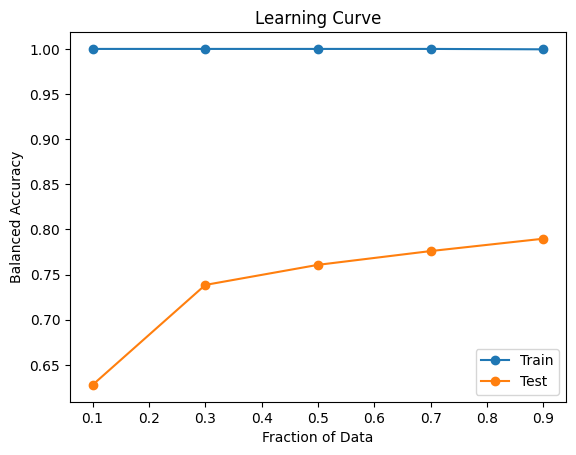

In [21]:
plt.plot(fractions, train_scores, 'o-', label='Train')
plt.plot(fractions, test_scores, 'o-', label='Test')
plt.xlabel('Fraction of Data')
plt.ylabel('Balanced Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

# 5. Use topic models to refine your answers.
What does a topic analysis show? Do we have the same error rate over all dataset? Or are there some topics in which classification is more effective? Test a two-layer classifier in which documents are first classified according to their topic, and are then redirected to a classifier focused solely on that specific topic.

In [36]:
def print_words_in_topics(nmf, vectorizer):
    words = vectorizer.get_feature_names_out()
    for i, topic in enumerate(nmf.components_):
        top_words = np.argsort(topic)[-10:]
        print(f'Topic {i}: {", ".join(words[top_words])}')

n = 10

vectorizer_nmf_pipeline = Pipeline([('vectorizer', CountVectorizer(binary=True, stop_words='english')),
                                    ('nmf', NMF(n_components=n, random_state=23))])
X_nmf = vectorizer_nmf_pipeline.fit_transform(df['processed_text'])

In [37]:
print_words_in_topics(vectorizer_nmf_pipeline['nmf'], vectorizer_nmf_pipeline['vectorizer'])

Topic 0: kid, best, need, know, child, thing, world, life, people, way
Topic 1: red, recipe, star, dress, fashion, style, best, week, look, photo
Topic 2: star, change, report, study, video, fashion, week, city, york, new
Topic 3: month, million, state, old, 10, woman, american, past, ago, year
Topic 4: little, summer, family, better, spend, holiday, long, season, good, time
Topic 5: father, mom, love, perfect, summer, valentine, mother, week, recipe, day
Topic 6: instagram, tumblr, pinterest, huffpost, facebook, style, twitter, check, sure, want
Topic 7: sure, little, video, sense, easy, feel, better, food, recipe, make
Topic 8: know, food, thing, love, video, really, think, feel, look, like
Topic 9: attack, week, police, obama, report, president, woman, said, state, say


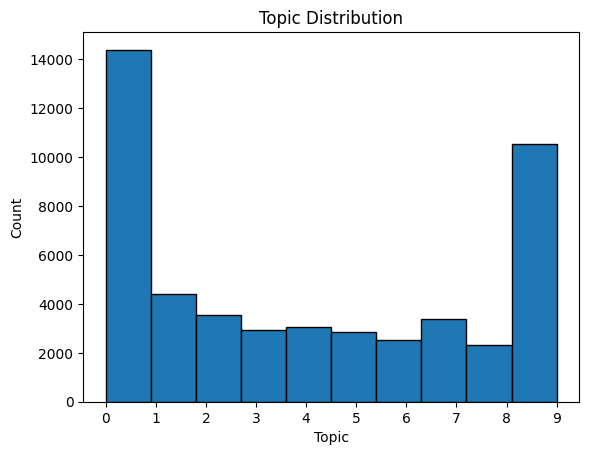

In [40]:
topic = np.argmax(X_nmf, axis=1)
# add delimiter to separate topics
plt.hist(topic, bins=len(set(topic)), edgecolor='black')
plt.xticks(range(n))
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()